In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
# The Time feature shows the absolute time of the transaction, which makes the data a bit hard to deal with here. 
#Therefore, we will just drop it
df1 = df.drop('Time', axis=1)

#### Preparing dataset

We are going to train our Autoencoder model, only using non-fraudulent cases. So when we deploy trained model, as the model has only seen non-fraudulent cases, it generates higher error-score when fraudulent case occurs

In [6]:
df2 = df1[df1['Class']==0]

In [7]:
X = df2.drop('Class', axis=1)
y = df2['Class']

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [10]:
df3= df1[df1['Class']==1]
X_test_new = df3.drop('Class', axis=1)
y_test_new = df3['Class']

X_test_final = pd.concat([X_test,X_test_new], axis=0)
y_test_final = pd.concat([y_test,y_test_new], axis=0)

In [11]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_final = pd.DataFrame(scaler.fit_transform(X_test_final), columns=X_test_final.columns)

Our input now has 29 dimensions, which we compress down to 12 dimensions before aiming to restore the original 29-dimensional output.While 12 dimensions is a somewhat arbitrary choice here, it allows for enough capacity to capture all the relevant information while still significantly compressing the data:

In [12]:
from keras.models import Model
from keras.layers import Input, Dense

Using TensorFlow backend.


In [13]:
data_in = Input(shape=(29,))
encoded = Dense(12,activation='tanh')(data_in)
decoded = Dense(29,activation='sigmoid')(encoded)
autoencoder = Model(data_in,decoded)

We are using the sigmoid activation function for the decoded data. This is only possible because we've scaled the data to have values between zero and one. We are also using a tanh activation within the encoded layer. This is just a style choice that worked well in experiments and ensures that encoded values are all between minus one and one. 

If we are working with images or deeper networks, a ReLU activation is usually a good choice. However, if we are working with a shallower network, as we are doing here, then a tanh activation often works well:

In [15]:
autoencoder.compile(optimizer='adam',loss='mean_squared_error')

In [16]:
autoencoder.fit(X_train,X_train,epochs = 20,batch_size=128,validation_data=(X_test_final ,X_test_final))

Train on 227452 samples, validate on 57355 samples
Epoch 1/20
227452/227452 [==============================] - 5s 21us/step - loss: 0.9181 - val_loss: 0.8525
Epoch 2/20
227452/227452 [==============================] - 5s 21us/step - loss: 0.8142 - val_loss: 0.8238
Epoch 3/20
227452/227452 [==============================] - 5s 21us/step - loss: 0.7918 - val_loss: 0.8104
Epoch 4/20
227452/227452 [==============================] - 5s 20us/step - loss: 0.7798 - val_loss: 0.8021
Epoch 5/20
227452/227452 [==============================] - 5s 22us/step - loss: 0.7721 - val_loss: 0.7965
Epoch 6/20
227452/227452 [==============================] - 5s 21us/step - loss: 0.7663 - val_loss: 0.7923
Epoch 7/20
227452/227452 [==============================] - 5s 21us/step - loss: 0.7619 - val_loss: 0.7890
Epoch 8/20
227452/227452 [==============================] - 4s 19us/step - loss: 0.7587 - val_loss: 0.7870
Epoch 9/20
227452/227452 [==============================] - 4s 19us/step - loss: 0.7564 - val

In this example, we've used a mean squared error loss. This seems a bit of an unusual choice at first, using a sigmoid activation with a mean squared error loss, yet it makes sense. Most people think that sigmoid activations have to be used with a cross-entropy loss, but cross-entropy loss encourages values to either be zero or one, which works well for classification tasks where this is the case.

In our credit card example, most values will be around 0.5. Mean squared error, which we can see being implemented in the code, is better at dealing with values where the target is not binary, but on a spectrum. Binary cross entropy forces values to be close to zero and one, which is not what we always want:

In [24]:
pred = autoencoder.predict(X_test_final)

In [25]:
pred.shape

(57355, 29)

#### Visualizing latent spaces with t-SNE

We now have an autoencoder that takes in a credit card transaction and outputs a credit card transaction that looks more or less the same. However, this is not why we built the autoencoder. The main advantage of an autoencoder is that we can now encode the transaction into a lower dimensional representation that captures the main elements of the transaction.

To create the encoder model, all we have to do is to define a new Keras model that maps from the input to the encoded state:

Note that you don't need to train this model again. The layers keep the weights from the previously trained autoencoder.

To encode our data, we now use the encoder model:

In [26]:
encoder = Model(data_in,encoded)

In [27]:
enc = encoder.predict(X_test_final)

But how would we know whether these encodings contain any meaningful information about fraud? Once again, visual representation is key. While our encodings have fewer dimensions than the input data, they still have 12 dimensions. It's impossible for humans to think about a 12-dimensional space, so we need to draw our encodings in a lower dimensional space while still preserving the characteristics we care about.

#### t-SNE

We first import the TSNE class, and then we can create a new TSNE instance. We define that we want to train for 5000 epochs, and use the default perplexity of 30 and the default learning rate of 200. We also specify that we would like output during the training process. We then call fit_transform, which transforms our 12 encodings into 2-dimensional projections:

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1,n_iter=5000)
res = tsne.fit_transform(enc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 57355 samples in 0.127s...
[t-SNE] Computed neighbors for 57355 samples in 92.706s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57355
[t-SNE] Computed conditional probabilities for sample 2000 / 57355
[t-SNE] Computed conditional probabilities for sample 3000 / 57355
[t-SNE] Computed conditional probabilities for sample 4000 / 57355
[t-SNE] Computed conditional probabilities for sample 5000 / 57355
[t-SNE] Computed conditional probabilities for sample 6000 / 57355
[t-SNE] Computed conditional probabilities for sample 7000 / 57355
[t-SNE] Computed conditional probabilities for sample 8000 / 57355
[t-SNE] Computed conditional probabilities for sample 9000 / 57355
[t-SNE] Computed conditional probabilities for sample 10000 / 57355
[t-SNE] Computed conditional probabilities for sample 11000 / 57355
[t-SNE] Computed conditional probabilities for sample 12000 / 57355
[t-SNE] Computed conditional probabilities for sa

We can then plot our t-SNE results as a scatterplot. For illustration, we will distinguish frauds from non-frauds by color, with frauds being plotted in red and non-frauds being plotted in blue. Since the actual values of t-SNE do not matter as much, we will hide the axes:

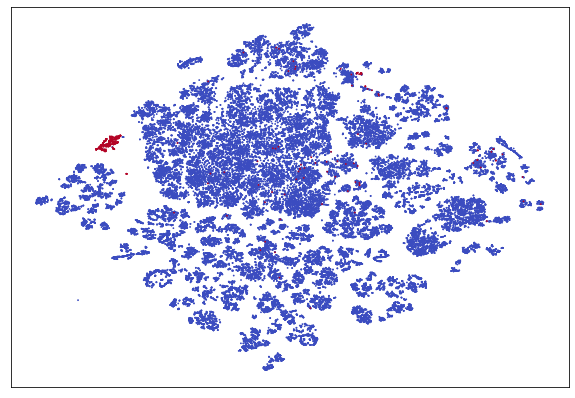

In [28]:
fig = plt.figure(figsize=(10,7))
scatter =plt.scatter(res[:,0],res[:,1],c=y_test_final, cmap='coolwarm', s=0.6)
scatter.axes.get_xaxis().set_visible(False)
scatter.axes.get_yaxis().set_visible(False)

You can see that the frauds are nicely separate from the rest of the genuine transactions, those in blue. Clearly, our autoencoder has found a way to distinguish frauds from the genuine transaction without being given labels. This is a form of unsupervised learning.

> Using our autoencoder, we could now use the encoded information as features for a classifier. 

> However, what's even better is that with only a slight modification of the autoencoder, we can generate more data that has the underlying properties of a fraud case while having different features. This is done with a variational autoencoder.